In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96_extrapolation/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5704992
drwx------ 3 root root       4096 May  6 21:15 gdrive
drwx------ 3 root root       4096 May  6 21:17 models
drwxr-xr-x 1 root root       4096 Apr 29 16:32 sample_data
drwx------ 3 root root       4096 May  6 21:17 tools
-rw------- 1 root root  584202368 May  6 21:16 X_test.npy
-rw------- 1 root root 1869364352 May  6 21:16 X_train.npy
-rw------- 1 root root  467361920 May  6 21:16 X_val.npy
-rw------- 1 root root  584202368 May  6 21:16 y_test.n

In [ ]:
!cp gdrive/My\ Drive/16/combined_2e-5/weights1 weights1

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import tools._my_tools as mt
import tools._torch_tools as tt
import models.loss as lo
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# data_folder = "dataset_extrapolation/"
data_folder = "datasets/dataset_extrapolation/"

Device is cpu


In [5]:
X_train, y_train = mt.loadData("",train=True,typeF='float16')

Loading X_train.npy
Loading y_train.npy


In [3]:
X_val, y_val = mt.loadData(data_folder,val=True,typeF='float16')

Loading datasets/dataset_extrapolation/X_val.npy
Loading datasets/dataset_extrapolation/y_val.npy


In [19]:
X_test, y_test = mt.loadData(data_folder,test=True,typeF='float16')

Loading datasets/dataset_extrapolation/X_test.npy
Loading datasets/dataset_extrapolation/y_test.npy


In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(3, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
    
    def predict(self,x,num_steps):
        assert x.shape[1] == 3
        
        def_shape = x.shape
        res = []
    
        for i in range(def_shape[0]): 
            tmp = []
            x_tmp = x[i:i+1]
            for i in range(num_steps):
                out = self.forward(x_tmp)
                tmp.append(out)
                x_tmp = torch.cat((x_tmp[:,1:,:,:],out),1)
            
            tmp = torch.cat(tmp,dim=1).view(1,num_steps,def_shape[2],def_shape[3])
            res.append(tmp)
            
        res = torch.cat(res,dim=0)
        return res.view(def_shape[0],num_steps,def_shape[2],def_shape[3])
    
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), nn.PReLU()
        )

class Training(tt.Training):
    def __init__(self,*args,**kwargs):
        super(Training,self).__init__(*args,**kwargs)
        
    def getBatch(self, offset, batch_size, val=False):
        input,target = super(Training,self).getBatch(offset, batch_size, val=val)
        target = target[:,:1,:,:]
        
        return input, target

In [6]:
model = Model()
model.load_state_dict(torch.load("16/weights30.pth"))
# loss = lo.CombinedLoss()
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=nn.L1Loss())
training.history = mt.fromCSV("16/history.csv")

In [7]:
try:
    training.fit(32,20,val=True, save="16/", save_off=30)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[31](2112/2112): Loss: 0.0168	ETA 0:00:00	Epoch Loss: 0.0196
Epoch[31] finished in 0:02:34 with loss 0.019618837726849244
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0202
Validation loss = 0.0202

----------------------------

===> Epoch[32](2112/2112): Loss: 0.0168	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[32] finished in 0:02:32 with loss 0.019522349529187053
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0202
Validation loss = 0.0202

----------------------------

===> Epoch[33](2112/2112): Loss: 0.0172	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[33] finished in 0:02:34 with loss 0.0195094537074593
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0203
Validation loss = 0.0203

----------------------------

===> Epoch[34](2112/2112): Loss: 0.0169	ETA 0:00:00	Epoch Loss: 0.0195
Epoch[34] finished in 0:02:32 with loss 0.019474315369293574
Valid

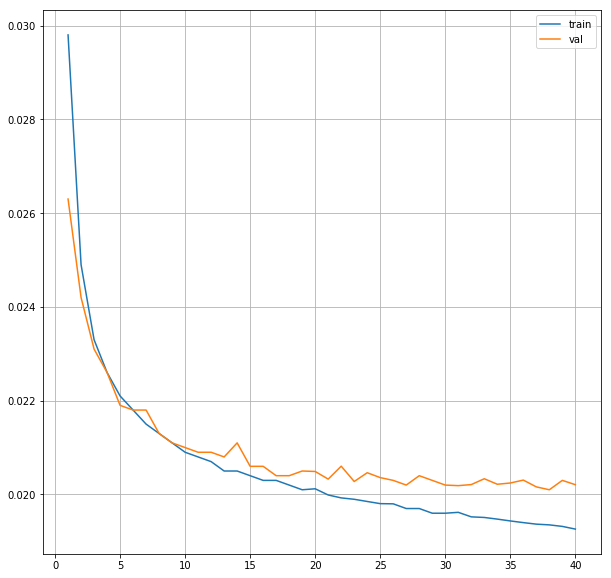

In [9]:
mt.plotHistory(training.history)

In [10]:
mt.toCSV("16/history.csv",training.history)

### Training with perceptual loss

In [8]:
model = Model()
model.load_state_dict(torch.load("16/comb/weights10.pth"))
loss = lo.CombinedLoss(-18,0.00001)
training = Training(model,device,X_train, y_train, X_val, y_val, loss_function=loss)
training.history = mt.fromCSV("16/comb/history.csv")

In [15]:
try:
    training.fit(32, 15,val=True,save="16/comb/",save_off=25)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[26](2112/2112): Loss: 0.0308	ETA 0:00:00	Epoch Loss: 0.0345
Epoch[26] finished in 0:03:10 with loss 0.03445934493069989
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0359
Validation loss = 0.0359

----------------------------

===> Epoch[27](2112/2112): Loss: 0.0311	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[27] finished in 0:03:10 with loss 0.03444547412624216
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0360
Validation loss = 0.0360

----------------------------

===> Epoch[28](2112/2112): Loss: 0.0308	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[28] finished in 0:03:09 with loss 0.03441135860030596
Validating on 16896 samples.
===> Validating (528/528):	ETA 0:00:00	Validation Loss: 0.0359
Validation loss = 0.0359

----------------------------

===> Epoch[29](2112/2112): Loss: 0.0310	ETA 0:00:00	Epoch Loss: 0.0344
Epoch[29] finished in 0:03:10 with loss 0.0343956585989376
Validati

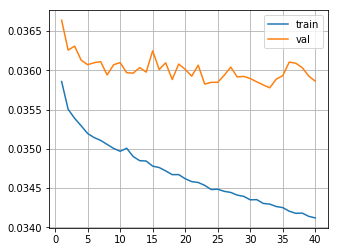

In [25]:
mt.plotHistory(training.history,save="16/comb/history.png",size=(5,4))
mt.toCSV("16/comb/history.csv",training.history)

### SSIM test set validation

In [27]:
def toTensor(x):
    return torch.tensor(x,dtype=torch.float).view(1,-1,96,96).to(device)

In [28]:
ssim = lo.SSIMLoss()
model = Model().to(device)
model.load_state_dict(torch.load("16/final/weights40.pth",map_location=device))
model.eval()

dic = mt.fromCSV("16_cotrec_comparison/results.csv")

In [44]:
res = [0.,0.,0.]
for i in range(len(X_test)):
    out = model.predict(toTensor(X_test[i:i+1]),3)
#     print(out.shape)
#     print(y_test.shape)
    for j in range(3):
        res[j] += ssim(out[:,j:j+1],toTensor(y_test[i:i+1,j:j+1]))
        
    if i % 8 == 0:
        print('\r'+str(i).zfill(5)+" "+str(res[0]/(i+1)),end='',flush=True)

print("")
for i in range(3):
    res[i] = res[i] / len(X_test)
    print(res[i])
    print("================")

00520 0.8445780450902934

KeyboardInterrupt: 

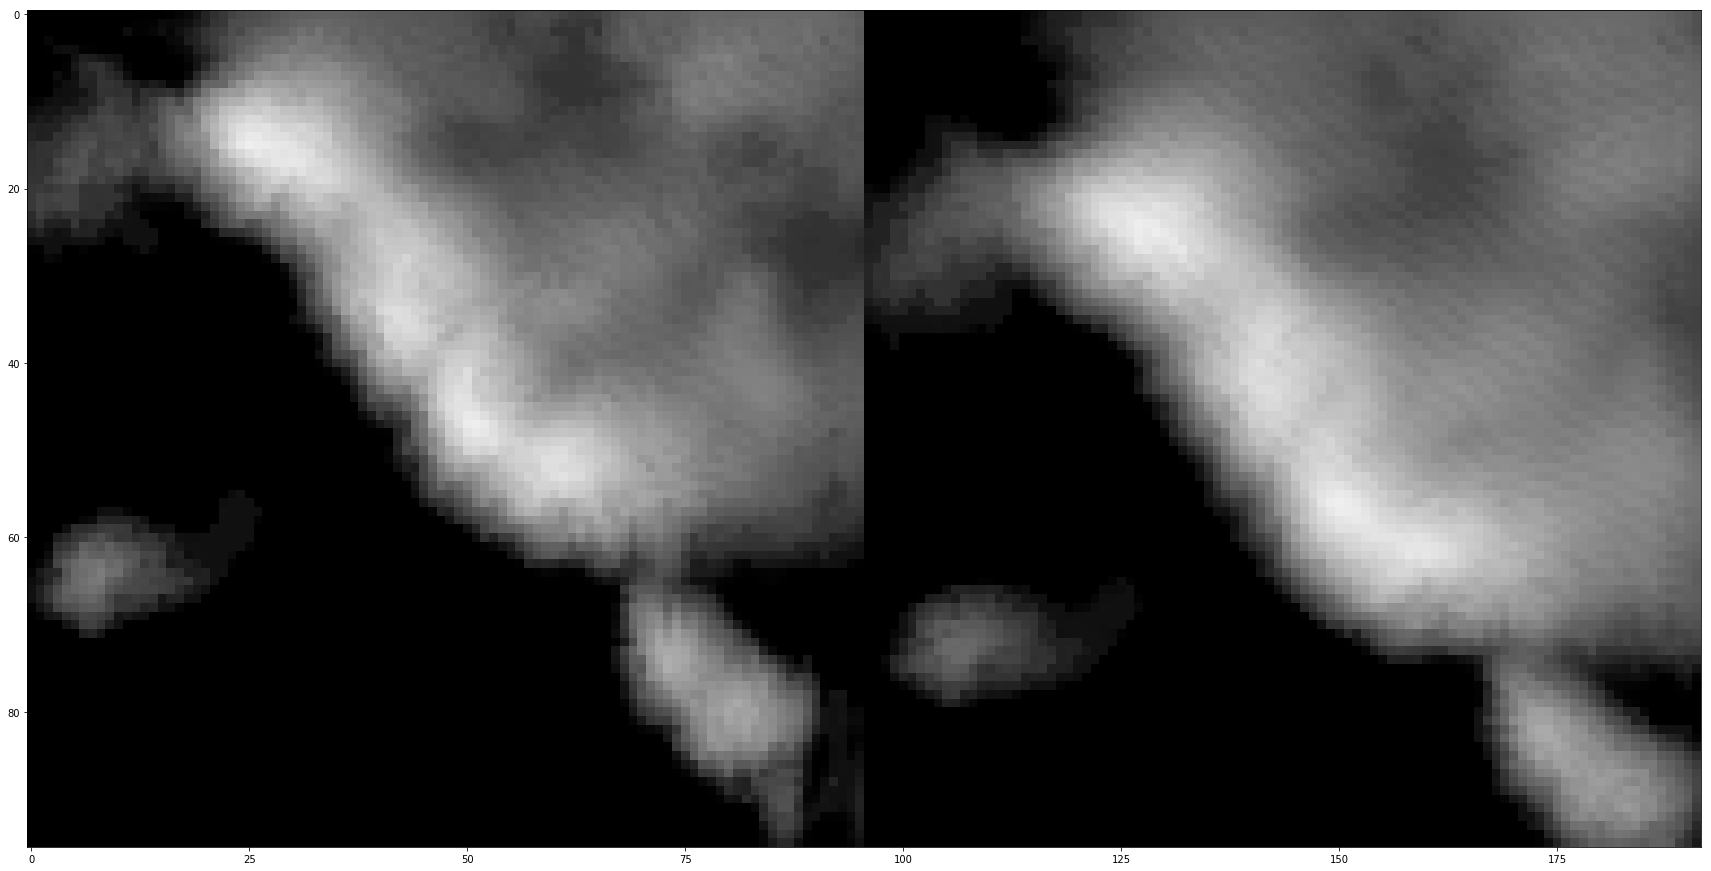

In [36]:
mt.showImgGC("",out[0,0],out[0,1])

In [20]:
def validateSSIM(in_weights, X_set, y_set):
    model = Model()
    model.load_state_dict(torch.load(in_weights))
    model.eval()
    validating = Training(model,device,X_set, y_set, X_set, y_set, loss_function=lo.SSIMLoss())
   
    return validating.validate(1)

final_ssim = validateSSIM("16/comb/weights40.pth", X_test, y_test)

Validating on 21130 samples.
===> Validating (21130/21130):	ETA 0:00:00	Validation Loss: 0.6925
Validation loss = 0.6925


In [22]:
dic = {'model':['final'],'ssim':[final_ssim]}
mt.toCSV("16/test_ssim.csv",dic)

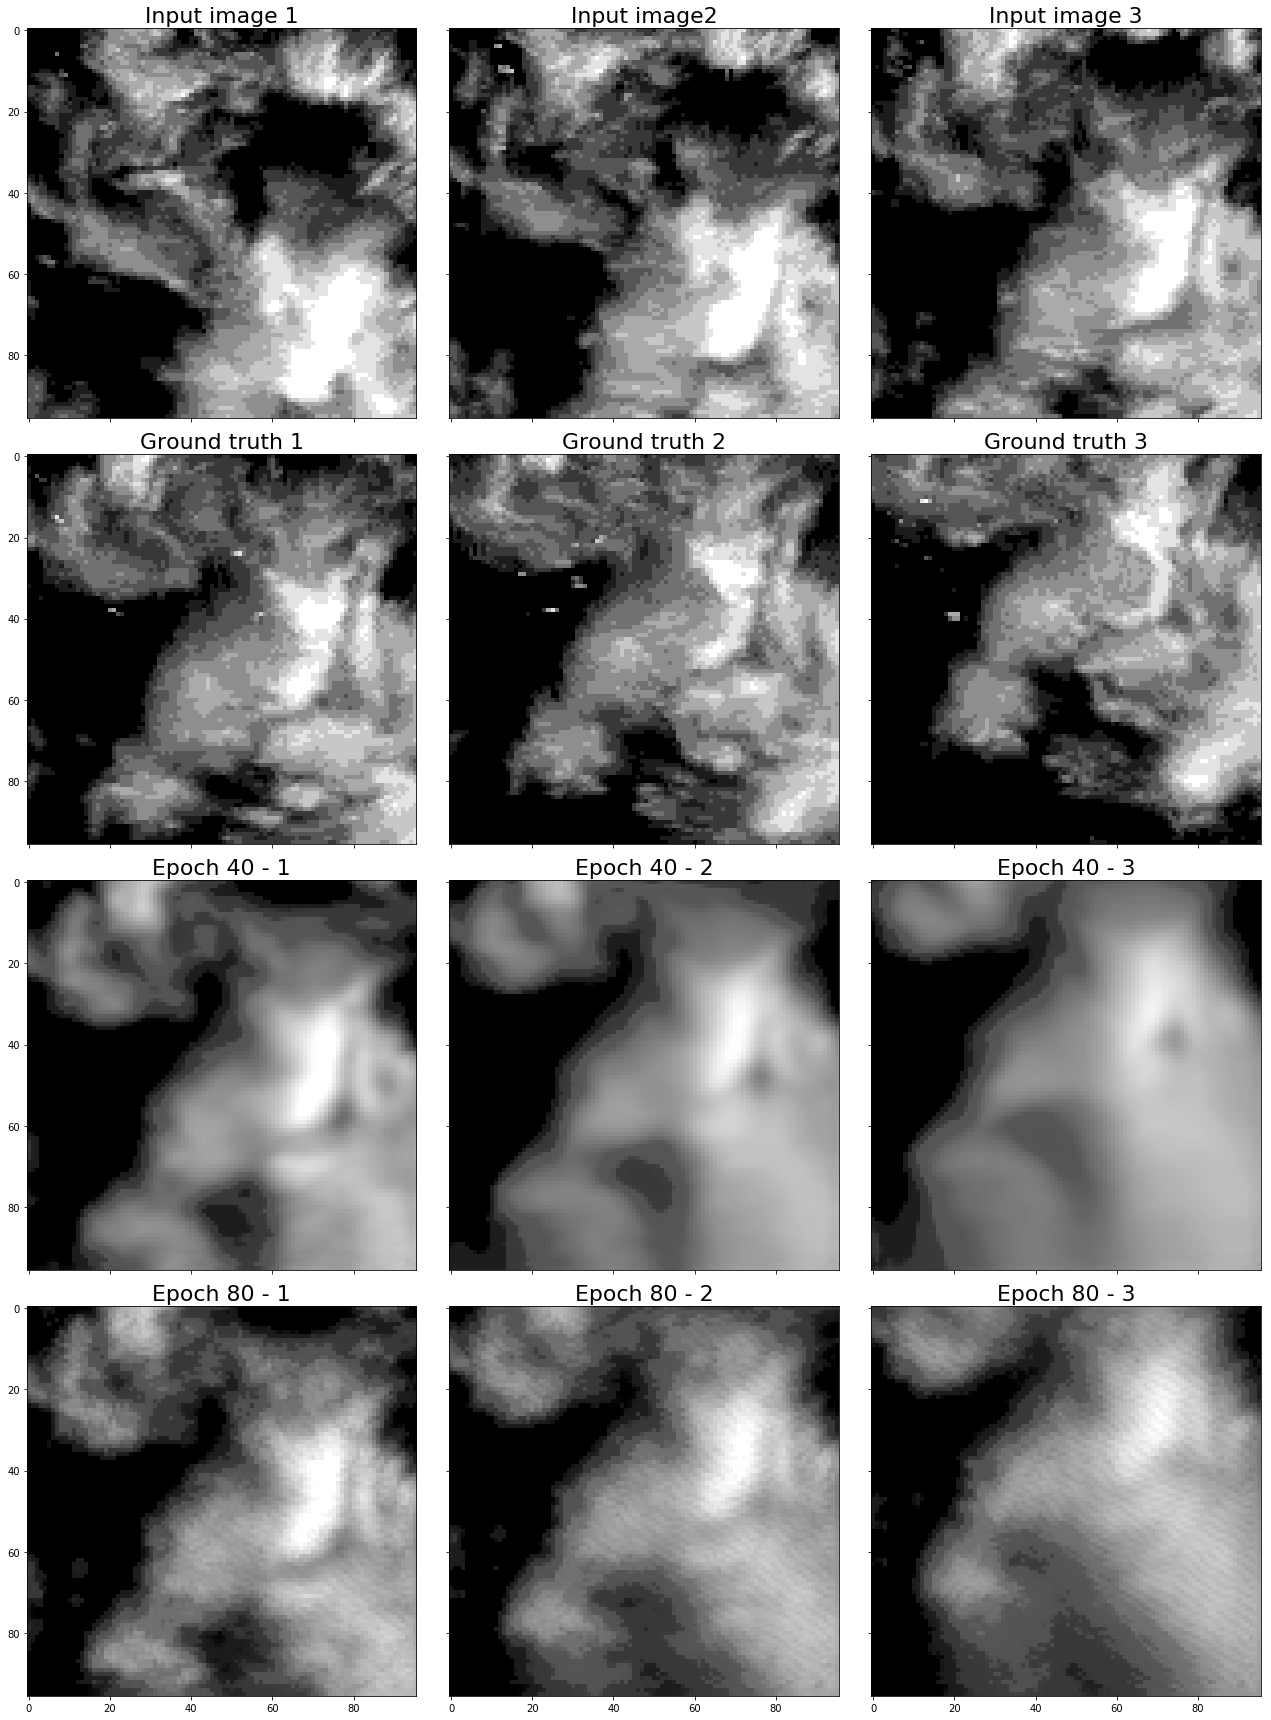

In [17]:
import matplotlib.pyplot as plt

X = X_val[5:6]
Y = y_val[5:6]
model = Model()
model.to(device)

model.load_state_dict(torch.load("16/weights40.pth",map_location=device))
model.eval()
out1 = model.predict(torch.tensor(X, dtype=torch.float).to(device), 3).cpu().detach().numpy()

model.load_state_dict(torch.load("16/final/weights40.pth",map_location=device))
model.eval()
out2 = model.predict(torch.tensor(X, dtype=torch.float).to(device),3).cpu().detach().numpy()

# model.load_state_dict(torch.load("12/comb1/weights35.pth",map_location=device))
# model.eval()
# out3 = model(torch.tensor(X, dtype=torch.float).to(device)).cpu().detach().numpy()

names = ['Input image 1','Input image2','Input image 3',
         'Ground truth 1', 'Ground truth 2', 'Ground truth 3',
         'Epoch 40 - 1','Epoch 40 - 2','Epoch 40 - 3',
         'Epoch 80 - 1', 'Epoch 80 - 2', 'Epoch 80 - 3',]
triplets = [X, Y, out1, out2]

COL = 12
SCALE = 4
fig, axes = plt.subplots(nrows=len(X)*SCALE, ncols=COL//SCALE, figsize=(COL*6//SCALE, SCALE*len(X)*6),
                         sharex=True, sharey=True)
ax = axes.ravel()
for i in range(len(X)):
    for j in range(SCALE):
        ax[i*COL+j*3].imshow(triplets[j][i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
        ax[i*COL+j*3+1].imshow(triplets[j][i,1].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
        ax[i*COL+j*3+2].imshow(triplets[j][i,2].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    
#     ax[i*COL].imshow(X[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+1].imshow(X[i,1].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+2].imshow(X[i,2].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    
#     ax[i*COL+3].imshow(Y[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+4].imshow(Y[i,1].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+5].imshow(Y[i,2].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    
#     ax[i*COL+6].imshow(out1[i,0].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+7].imshow(out1[i,1].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
#     ax[i*COL+8].imshow(out1[i,2].astype('float32'), cmap=plt.cm.gray, vmin=0, vmax=0.6)
    
    for j in range(COL):
        ax[i*COL+j].set_title(names[j],fontsize=22)
    
plt.tight_layout()
# plt.show()
plt.savefig("16/training_example.png")

In [7]:
X.shape

(10, 3, 96, 96)

--------------------------

In [ ]:
!cp weights1 gdrive/My\ Drive/16/combined_2e-5/weights1
!cp weights2 gdrive/My\ Drive/16/combined_2e-5/weights2
# !cp weights6 gdrive/My\ Drive/16/weights25
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/16/combined_2e-5/.

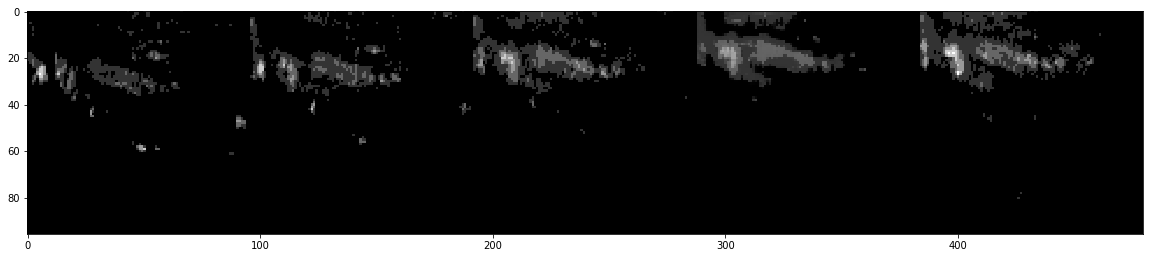

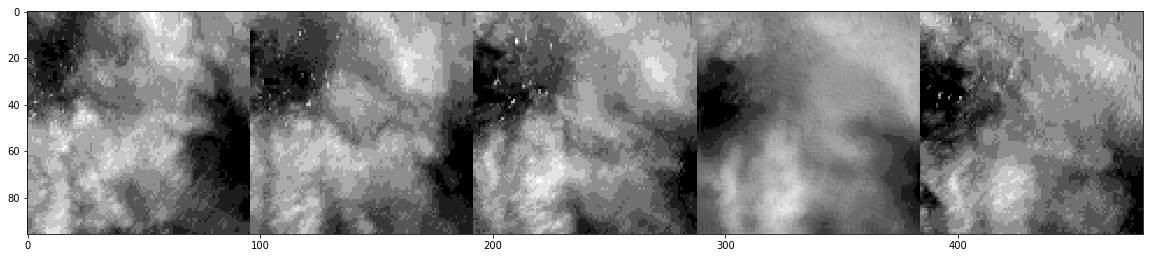

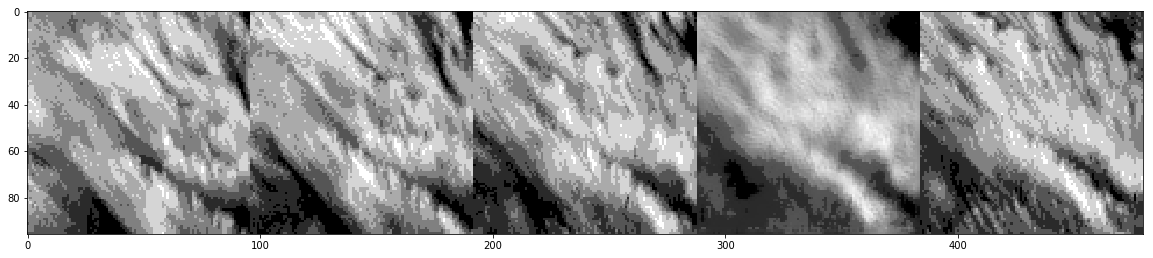

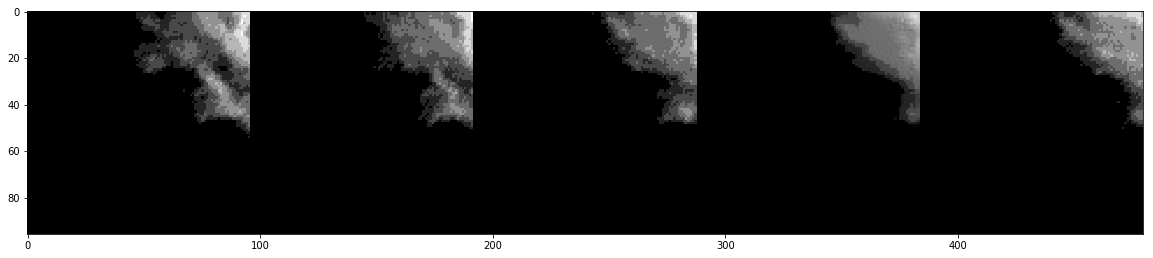

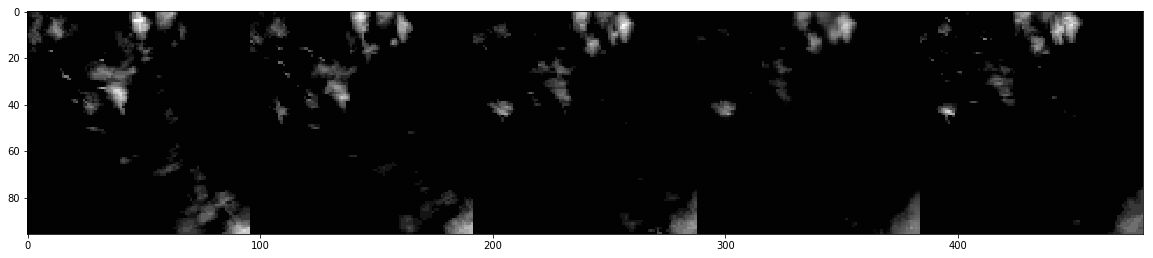

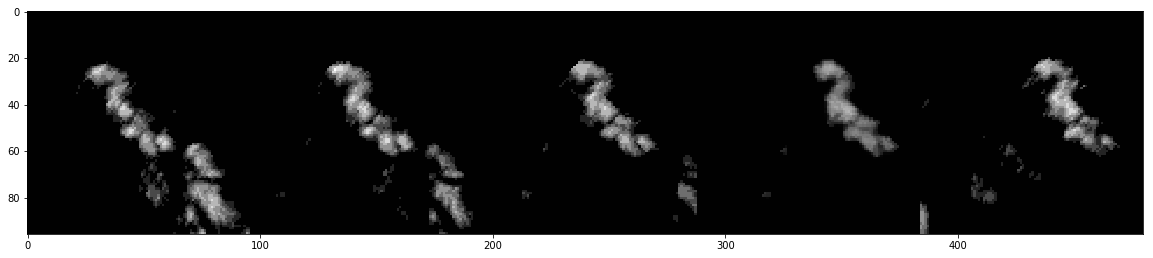

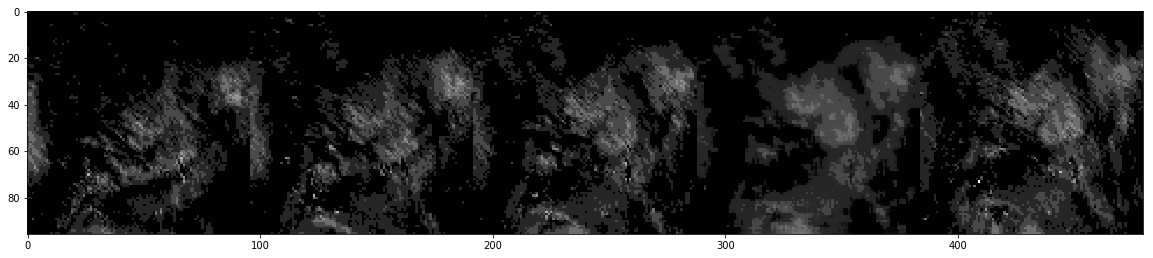

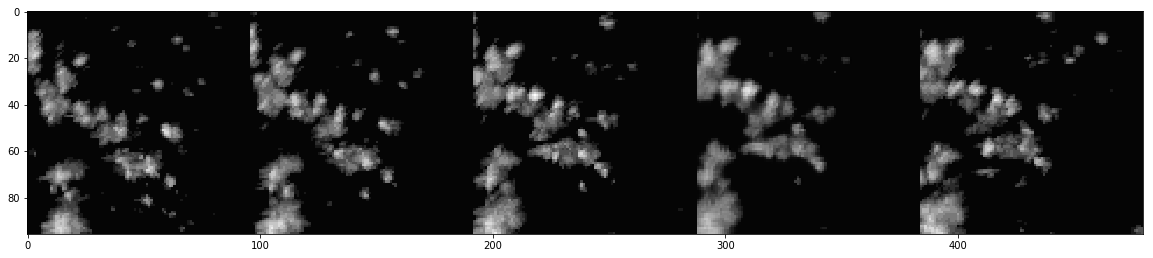

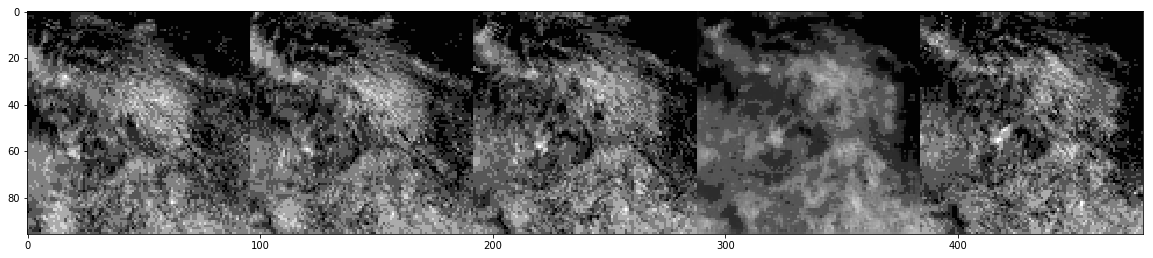

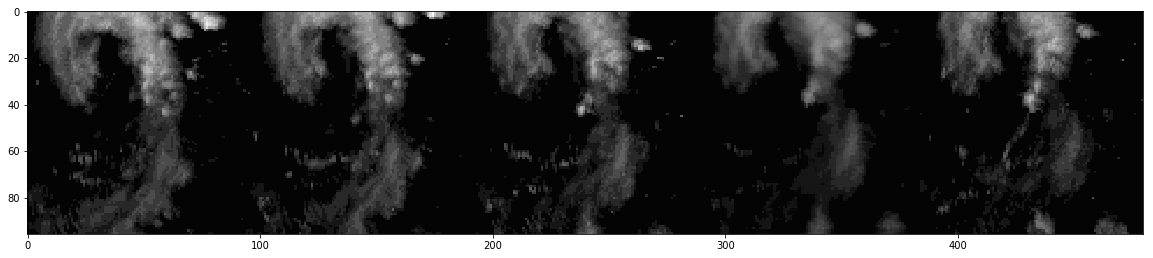

In [ ]:
!mkdir -p img

out = model( torch.tensor(X_train[0:10], dtype=torch.float).to(device) ).cpu().detach().numpy()
for i in range(10):
    mt.showImgGC(str(i), X_train[i,0],X_train[i,1],X_train[i,2],out[i,0], y_train[i,0], folder='img/',size=(20,20))

(1, 3, 1, 96, 96)


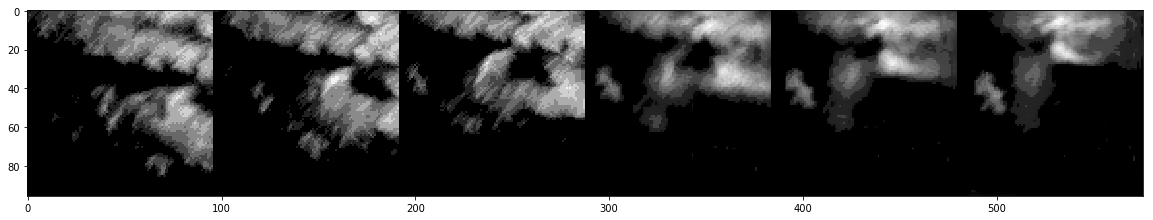

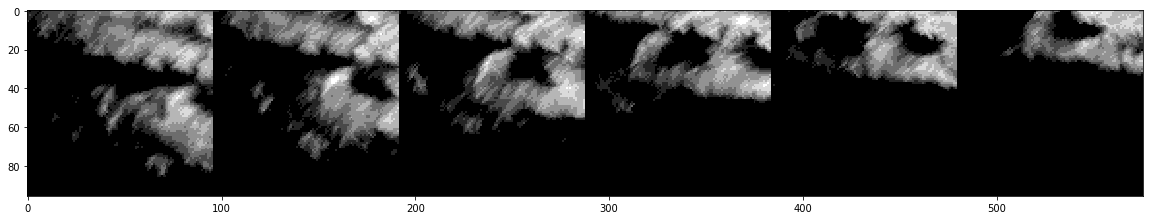

In [ ]:
i = 47

out = model.predict( torch.tensor(X_train[i:i+1], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
print(out.shape)
out = out.reshape((1,3,96,96))
mt.showImgGC("pred_my",X_train[i,0],X_train[i,1],X_train[i,2],out[0,0],out[0,1],out[0,2],folder="",size=(20,20))
mt.showImgGC("pred_gt",X_train[i,0],X_train[i,1],X_train[i,2],y_train[i,0],y_train[i,1],y_train[i,2],folder="",size=(20,20))

# for i in range(10):
# mt.showImgGC(str(i), X_train[i,0],X_train[i,1],X_train[i,2],out[i,0], y_train[i,0], folder='img/',size=(20,20))

(1, 3, 96, 96)


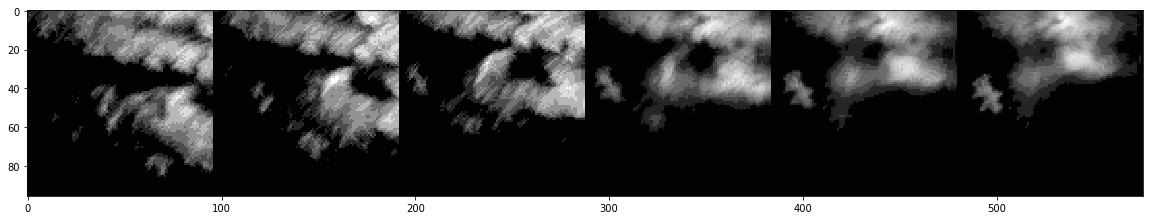

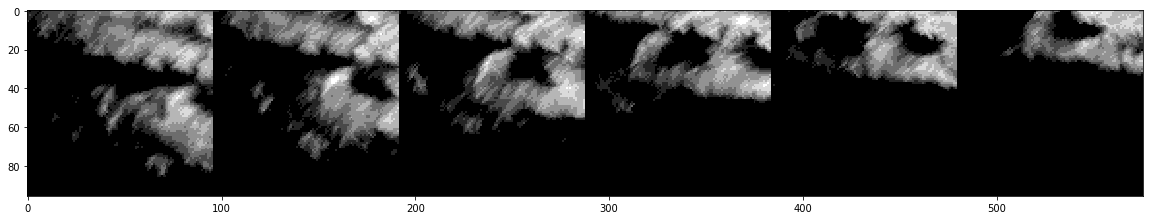

In [21]:
i = 47

out = model.predict( torch.tensor(X_train[i:i+1], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
print(out.shape)
out = out.reshape((1,3,96,96))
mt.showImgGC("pred_my",X_train[i,0],X_train[i,1],X_train[i,2],out[0,0],out[0,1],out[0,2],folder="",size=(20,20))
mt.showImgGC("pred_gt",X_train[i,0],X_train[i,1],X_train[i,2],y_train[i,0],y_train[i,1],y_train[i,2],folder="",size=(20,20))


In [ ]:
!mkdir -p img
for i in range(3):
    mt.showImgGC(str(i),X_train[47,i],folder="img/")
for i in range(3):
    mt.showImgGC(str(i+3),y_train[47,i],folder="img/")

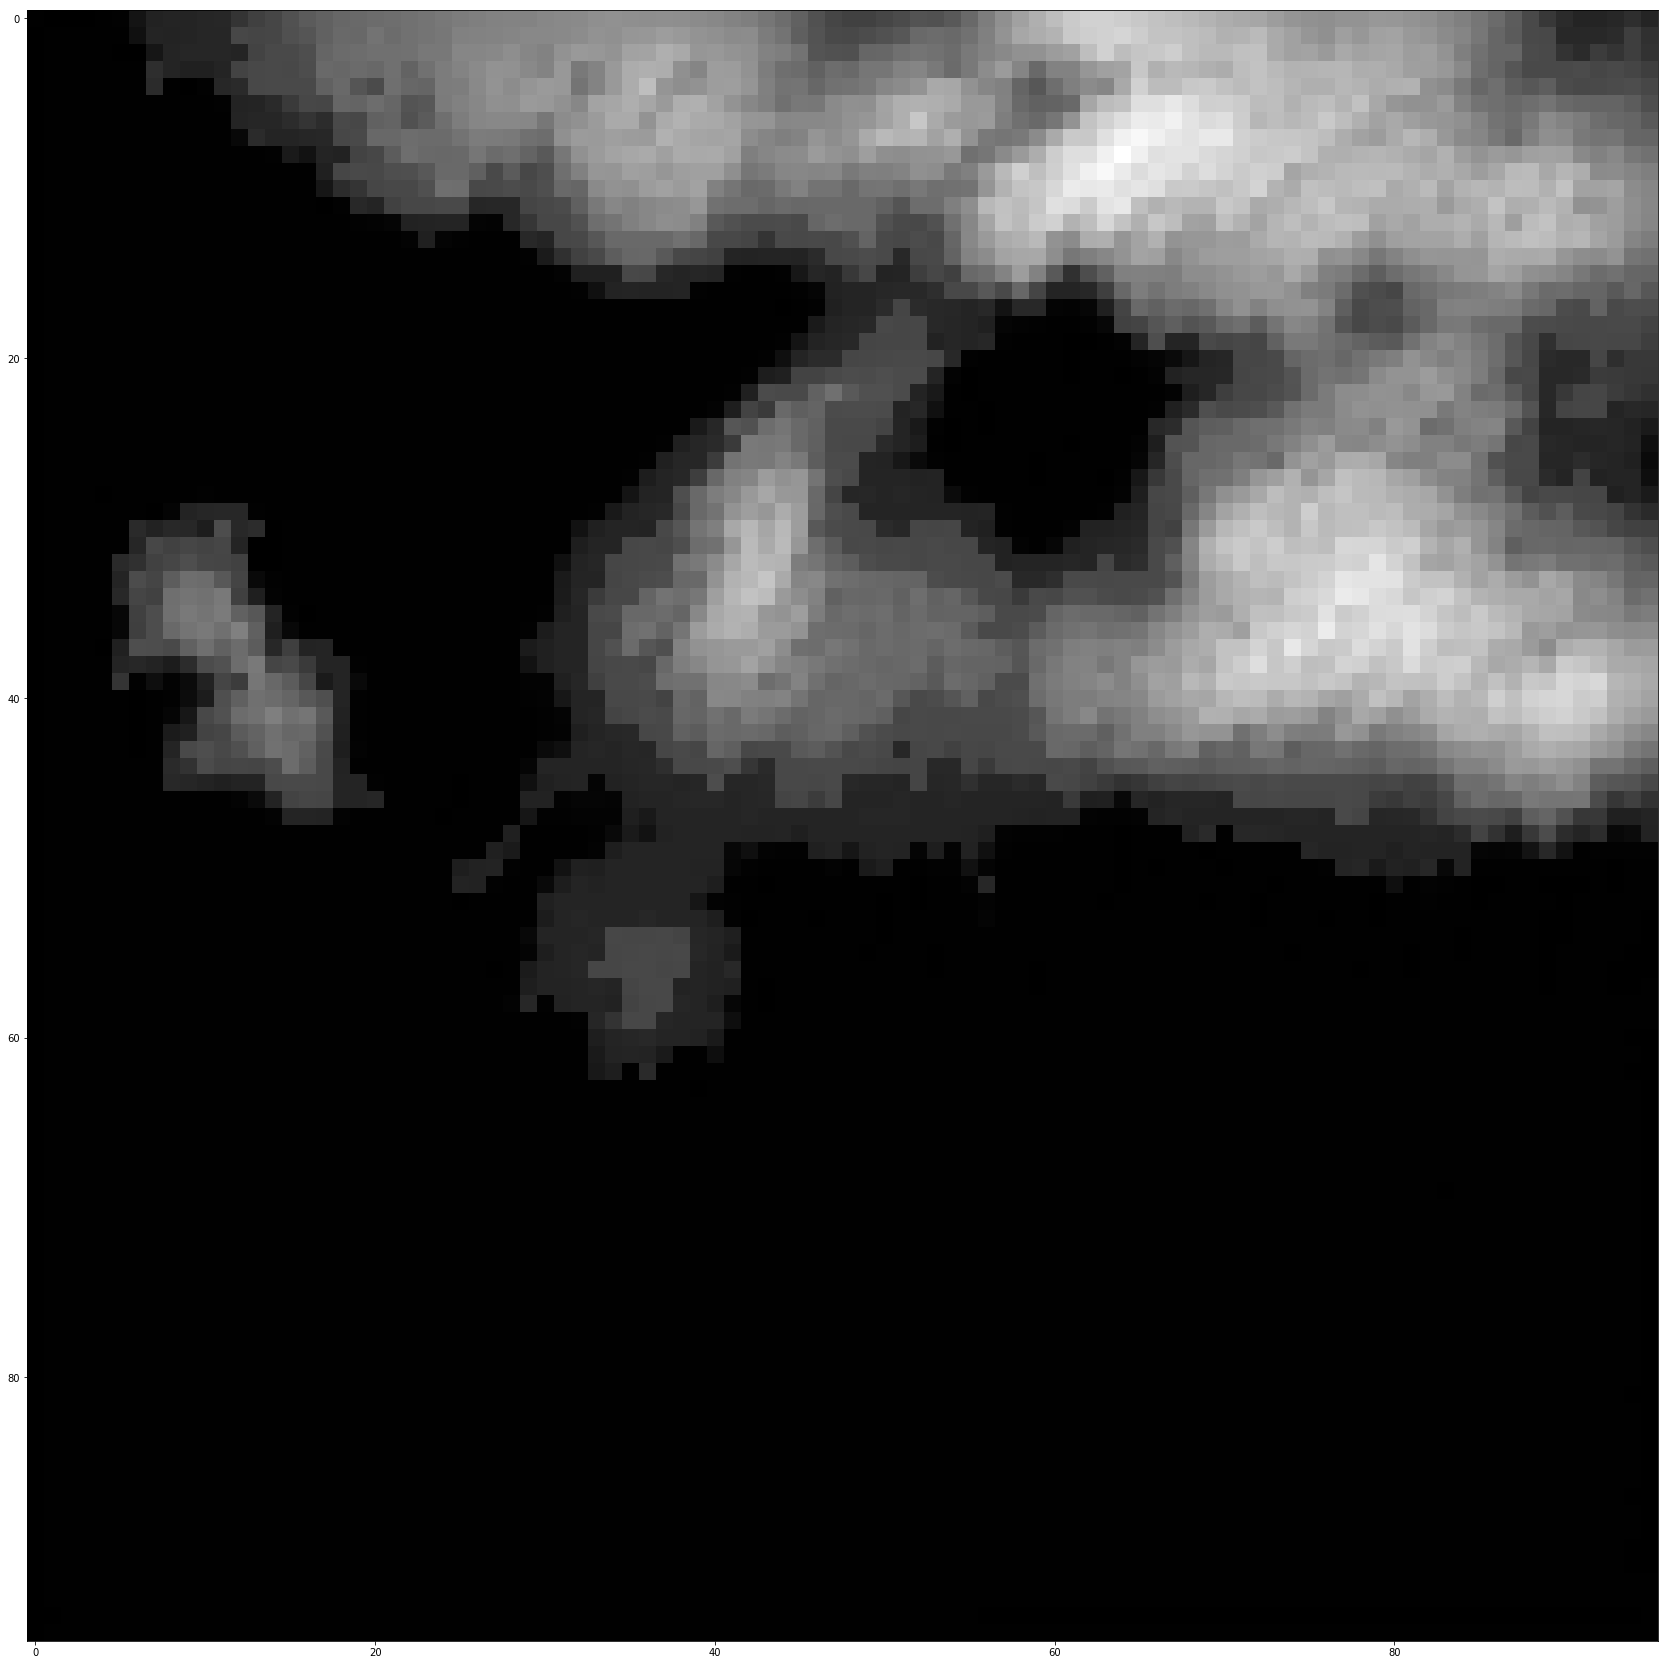

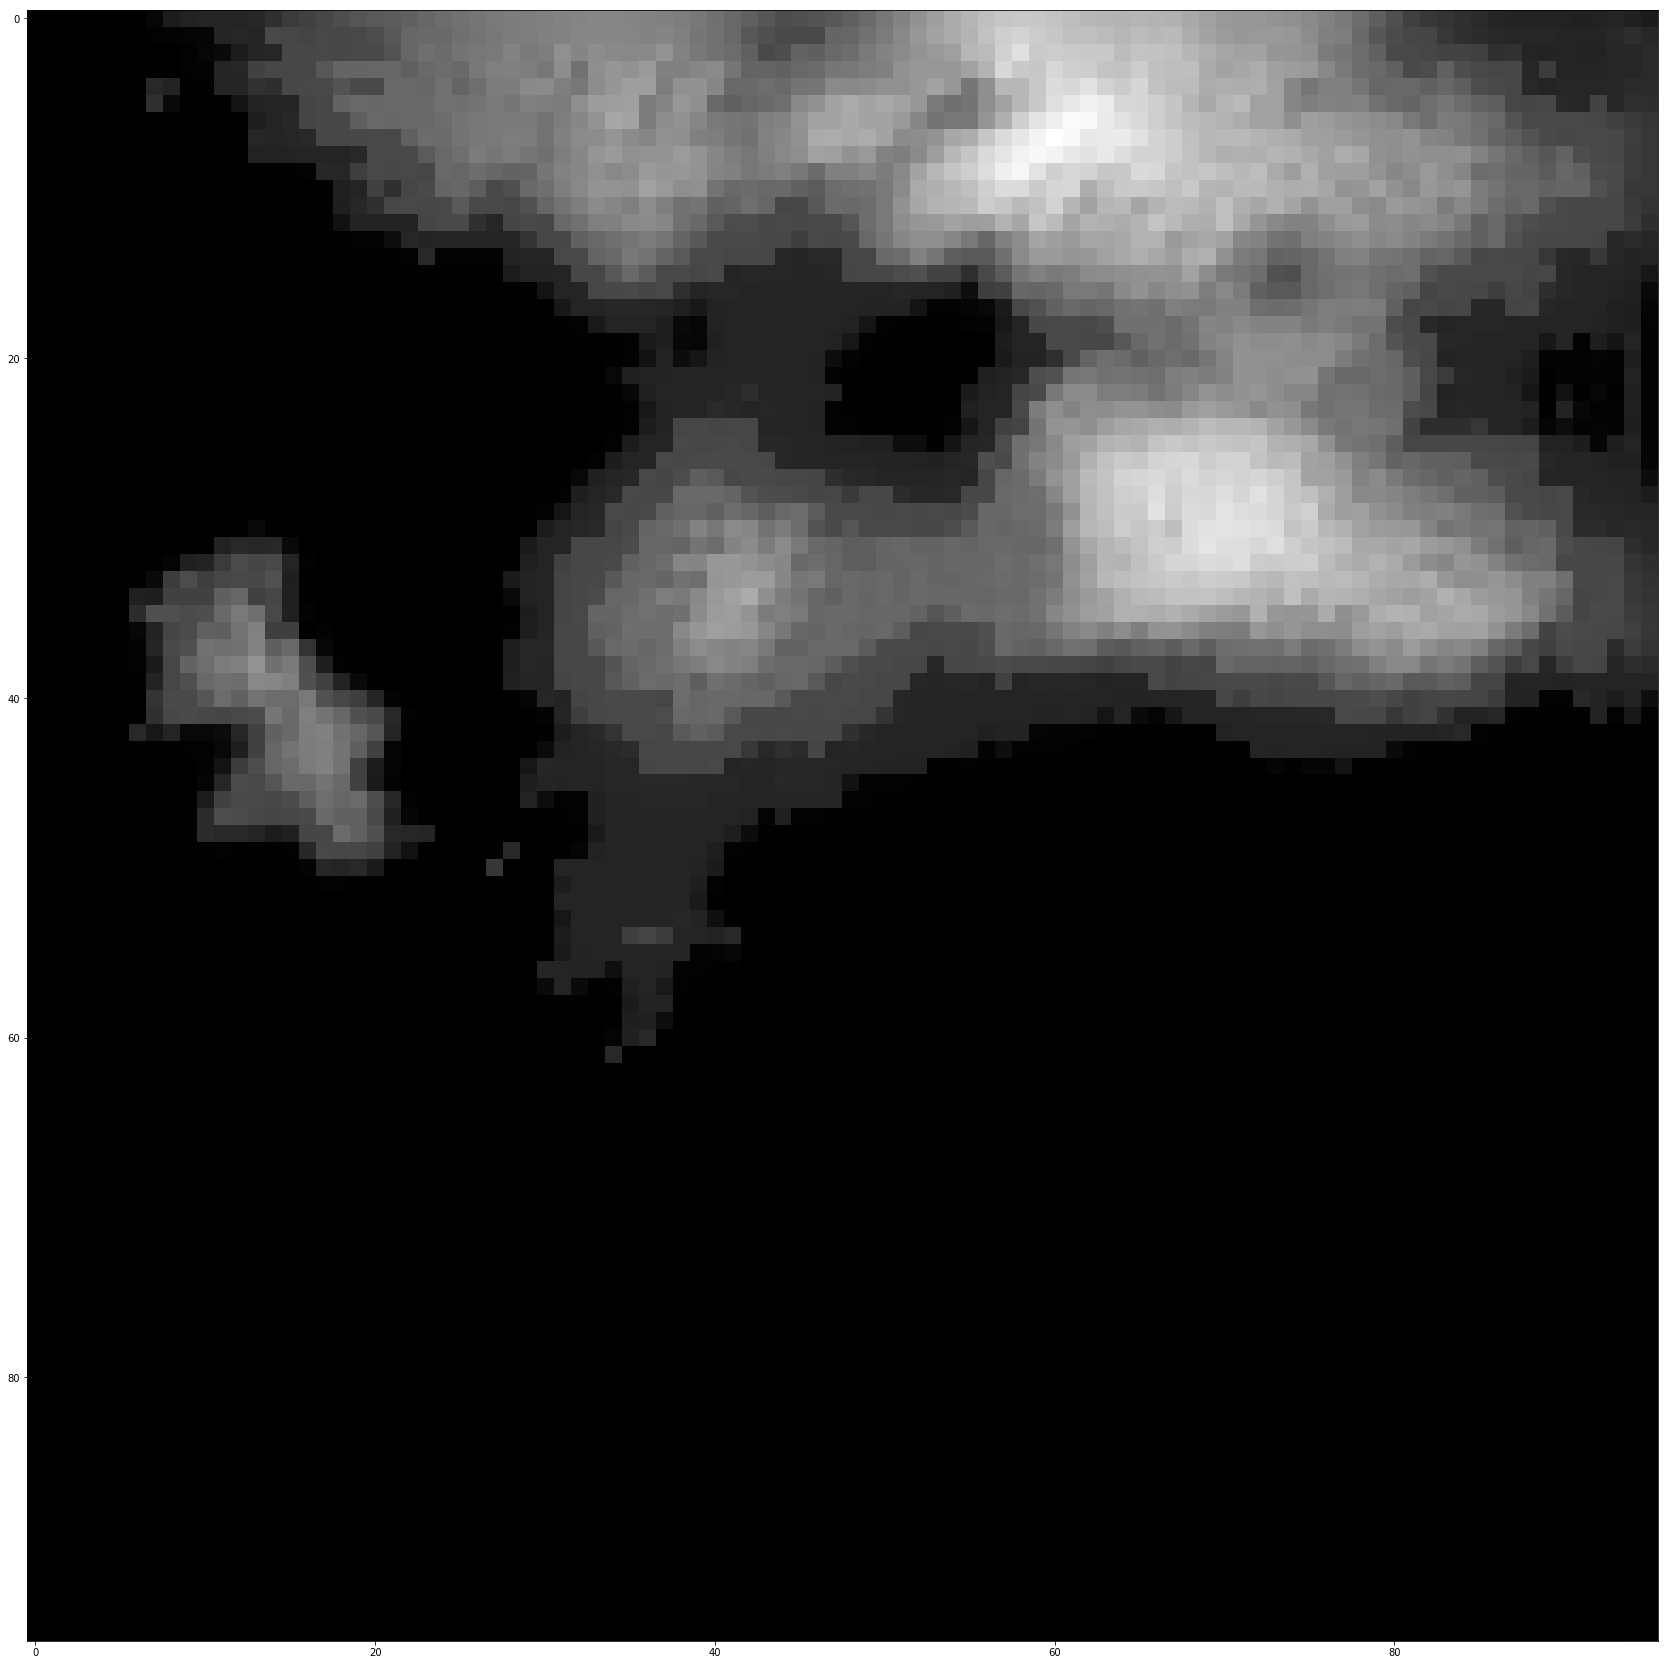

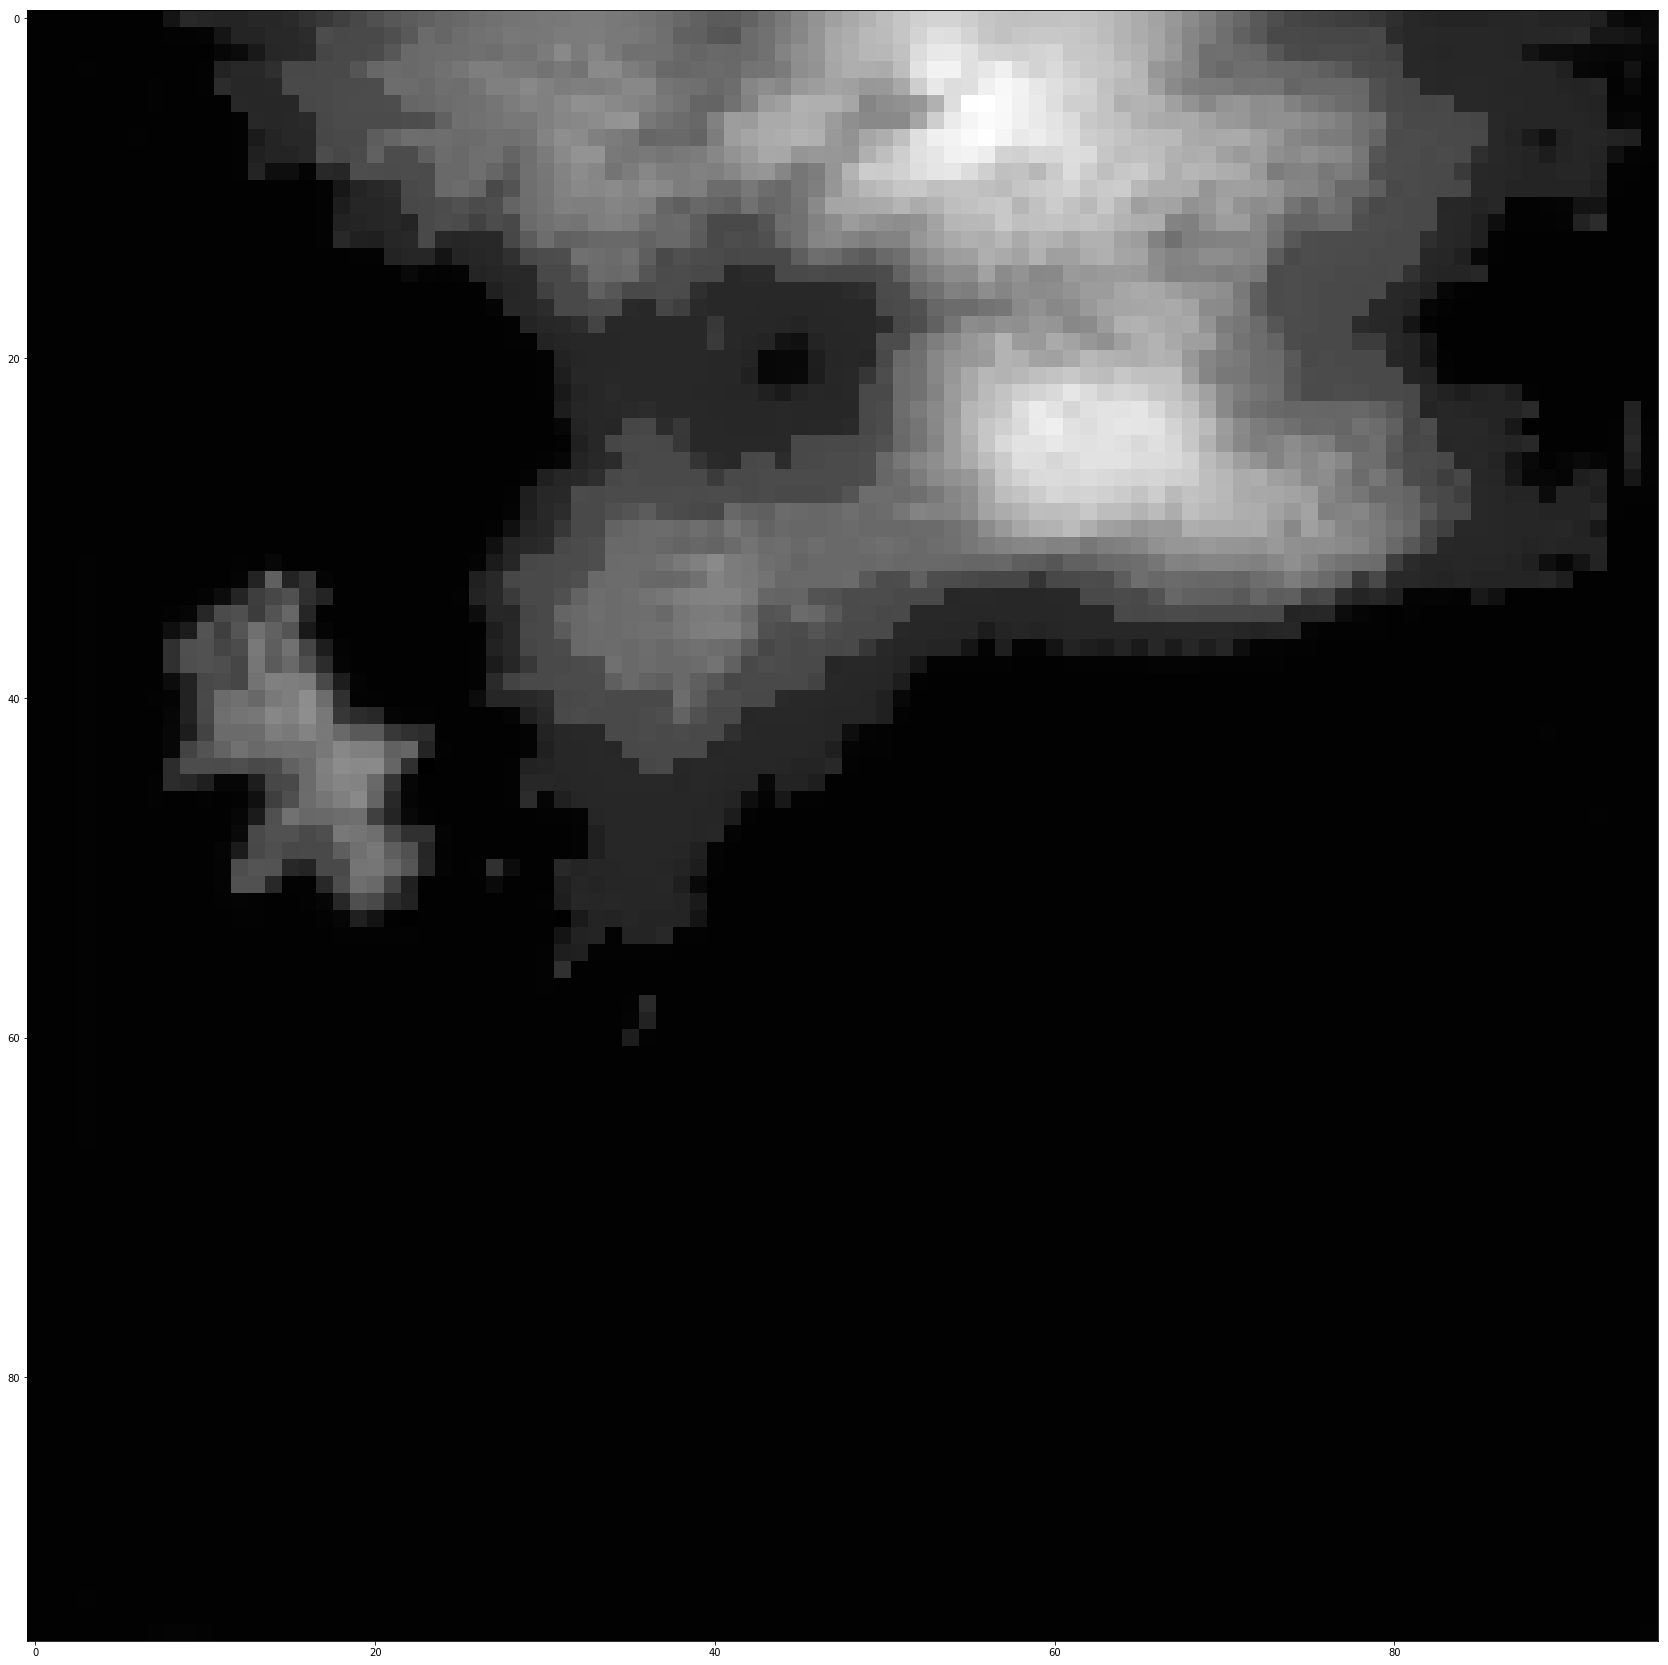

In [24]:
out = model.predict( torch.tensor(X_train[47:48], dtype=torch.float).to(device), 3 ).cpu().detach().numpy()
for i in range(3):
    mt.showImgGC("out_"+str(i),out[0,i],folder="img/")

In [25]:
!zip fig.zip img/*.png
# !cp fig.zip gdrive/My\ Drive/16/.

  adding: img/0.png (stored 0%)
  adding: img/1.png (stored 0%)
  adding: img/2.png (deflated 2%)
  adding: img/3.png (deflated 3%)
  adding: img/4.png (deflated 7%)
  adding: img/5.png (deflated 9%)
  adding: img/out_0.png (deflated 1%)
  adding: img/out_1.png (deflated 1%)
  adding: img/out_2.png (deflated 0%)


In [ ]:
training.history

{'train': [0.033530190842804695, 0.03307374570673952], 'val': []}